 # Лекционная часть

## Установка библиотек

In [1]:
!pip -qq install lightning transformers datasets evaluate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 3.0.0 requires httpx==0.13.3, but you have httpx 0.23.3 which is incompatible.


In [2]:
import math
import numpy as np
import tqdm.notebook
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
L.seed_everything(0)

from transformers import AutoImageProcessor, ResNetForImageClassification
from transformers import AutoFeatureExtractor, VanForImageClassification
from datasets import load_dataset
import evaluate

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
Global seed set to 0


## Механизм внимания

Механизм внимания (Attention) это недавно появившаяся группа слоев в нейронных сетях, которая получила большое распространение за последние несколько лет. В литературе существует множество различных возможных определений, но здесь мы будем использовать следующее: механизм Attention описывает средневзвешенное значение элементов (последовательности) с весами, динамически вычисляемыми на основе входного запроса и ключей элементов. 

Так что же это на самом деле означает? 

Цель состоит в том, чтобы получить среднее значение по признакам нескольких элементов. Однако вместо того, чтобы взвешивать каждый элемент одинаково, мы хотим взвесить их в зависимости от их фактических значений. Другими словами, мы хотим динамически решать, на каких входных данных мы хотим концентрироваться больше, чем на других. В частности, механизм внимания обычно состоит из четырех частей:

* **Query**: Запрос — это вектор признаков, который описывает то, что мы ищем в последовательности, т.е. на что мы, возможно, хотели бы обратить внимание.
* **Keys**: Для каждого входного элемента у нас есть ключ, который снова является вектором объектов. Этот вектор признаков примерно описывает, что элемент "предлагает", или когда это может быть важно. Ключи должны быть сконструированы таким образом, чтобы мы могли идентифицировать элементы, на которые хотим обратить внимание, на основе запроса.
* **Values**: Для каждого входного элемента у нас также есть вектор значений. Этот вектор признаков — тот, по которому мы хотим провести усреднение.
* **Score function**: Чтобы оценить, на какие элементы мы хотим обратить внимание, нам нужно указать функцию оценки $f_{attn}$. Функция оценки принимает запрос и ключ в качестве входных данных и выводит вес оценки/внимания пары запрос-ключ. Обычно это реализуется с помощью простых показателей подобия, таких как скалярное произведение (Dot Product) или небольшой MLP.

Веса среднего значения вычисляются с помощью softmax по всем выходным данным функции оценки. Следовательно, мы присваиваем более высокий вес тем векторам значений, соответствующий ключ которых наиболее похож на запрос. Если мы попытаемся описать это с помощью псевдоматематики, мы можем написать:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Например, мы можем применить механизм внимания к последовательности слов следующим образом:

<center width="100%" style="padding:25px"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/attention_example.svg" width="750px"></center>

Для каждого слова у нас есть один ключ и один вектор. Запрос сравнивается со всеми ключами с помощью функции оценки (в данном случае скалярного произведения) для определения весовых коэффициентов. Softmax не визуализируется для простоты. Наконец, векторы значений всех слов усредняются с использованием весов внимания.

Существует огромное моножество механизмов внимания. Большинство из них различается тем, какие запросы они используют, как определяются векторы ключей и значений и какая функция оценки используется. В следующих разделах рассмотрим подробнее подобные реализации.

### Базовые механизмы

#### (Scaled) Dot Product Attention

Наша цель — создать механизм внимания, с помощью которого любой элемент в последовательности может уделять внимание любому другому, оставаясь при этом эффективным в вычислении. Dot Product Attention принимает в качестве входных данных набор запросов $Q\in\mathbb{R}^{T\times d_k}$, ключи $K\in\mathbb{R}^{T\times d_k}$ и значения $V\in\mathbb{R}^{T\times d_v}$, где $T$ — длина последовательности и $d_k,d_v$ — скрытые размерности для запросов/ключей и значений соответственно. Для простоты мы пока пренебрегаем batch измерением. 

Значение attention от элемента $i$ до $j$ основано на его сходстве с запросом $Q_i$и ключом $K_j$, используя скалярное произведение в качестве показателя сходства. В математике мы вычисляем Dot Product Attention следующим образом:
$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Матричное умножение $QK^T$ выполняет скалярное произведение для каждой возможной пары запросов и ключей, в результате чего получается матрица формы $T\times T$ . Каждая строка представляет логиты внимания для определенного элемента $i$ ко всем остальным элементам в последовательности. К ним мы применяем softmax и умножаем на вектор значений, чтобы получить средневзвешенное значение (веса определяются вниманием). Другой взгляд на этот механизм с помощью графа вычислений визуализирован ниже.

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/scaled_dot_product_attn.svg" width="230px"></center>

Один аспект, который мы еще не обсуждали, — это коэффициент масштабирования $1/\sqrt{d_k}$. Этот коэффициент масштабирования имеет решающее значение для поддержания соответствующей дисперсии значений внимания после инициализации. Помните, что мы инициализируем наши слои с намерением иметь равную дисперсию по всей модели, следовательно, $Q$ и $K$ также могут иметь дисперсию, близкую к $1$. Однако выполнение скалярного произведения по двум векторам с дисперсией $\sigma$ приводит к скаляру, имеющему в $d_k$ раз большую дисперсию:

$$q_i \sim N(0,\sigma), k_i \sim N(0,\sigma) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma\cdot d_k$$

Если мы не уменьшим дисперсию обратно до $\sigma$, softmax по логитам уже будет насыщен до 1 для случайного элемента и 0 для всех остальных. Градиенты через softmax будут близки к нулю, так что мы не сможем соответствующим образом обучить параметры.

Блок Mask (opt.) на приведенном выше графе представляет собой необязательную маскировку определенных записей в матрице внимания. Это, например, используется, если мы складываем несколько последовательностей разной длины в batch. Чтобы была возможность использовать распараллеливание в PyTorch, мы заполняем предложения одинаковой длиной и маскируем маркеры заполнения во время вычисления значений внимания. Обычно это делается путем установки соответствующих логитов внимания на очень низкое значение.

После того, как мы обсудили детали блока Scaled Dot Product Attention, мы можем написать функцию, которая вычисляет выходные характеристики с учетом запросов, ключей и значений:

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

Приведенный выше код поддерживает любую дополнительную размерность перед текущей, так что мы также можем использовать его для batch. Для лучшего понимания давайте сгенерируем несколько случайных запросов, ключей и значений и рассчитаем выходные данные attention:

In [ ]:
embed_dim = 3
seq_1 = torch.randn(2, embed_dim)

q_1 = seq_1
k_1 = seq_1
v_1 = seq_1
values, attention = scaled_dot_product(q_1, k_1, v_1)

In [ ]:
print("Q\n", q_1)
print("K\n", k_1)
print("V\n", v_1)
print("Attention\n", attention)
print("Values\n", values)

Q
 tensor([[ 0.4623,  0.3338,  1.6443],
        [-1.2535, -0.0592,  1.1878]])
K
 tensor([[ 0.4623,  0.3338,  1.6443],
        [-1.2535, -0.0592,  1.1878]])
V
 tensor([[ 0.4623,  0.3338,  1.6443],
        [-1.2535, -0.0592,  1.1878]])
Attention
 tensor([[0.7245, 0.2755],
        [0.2805, 0.7195]])
Values
 tensor([[-0.0103,  0.2256,  1.5186],
        [-0.7722,  0.0511,  1.3159]])


<center width="100%">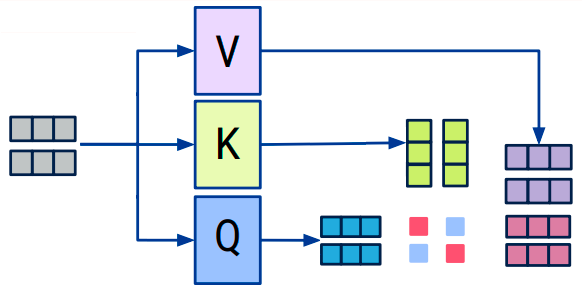</center>

Важно полностью понимать, как рассчитывается Scaled Dot Product Attention. Прежде чем использовать данный механизм, убедитесь, что вы осознаете принцип вычисления значений. Ниже приведена имплементация с помощью функциональной программирования в PyTorch:



```
values = F.scaled_dot_product_attention(q, k, v) # Добавлено в PyTorch v2.0.0
```

https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html



#### Multi-Head Attention

Механизм внимания с масштабированным скалярным произведением (Scaled Dot Product Attention) позволяет нейросети обращаться с последовательностью. Однако зачастую у элементов последовательности может быть несколько различных аспектов, на которые нужно обращать внимание, и один взвешенный средний результат не является оптимальным вариантом. Поэтому мы расширяем механизм внимания до нескольких голов, то есть до нескольких триплетов запрос-ключ-значение на одних и тех же признаках. В частности, мы преобразуем матрицы запросов, ключей и значений в $h$ подматриц, которые проходят через механизм внимания с масштабированным произведением точек независимо друг от друга. Затем мы конкатенируем головы и комбинируем их с конечной весовой матрицей. Математически это можно записать как:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$,
$W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ и $D$ — входная размерность.


Мы называем это Multi-Head Attention слой с обучающимися параметрами, *в отличии от простого Scaled Dot Product Attention*. В виде вычислительного графа, мы можем визуализировать механизм следующим образом:

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/multihead_attention.svg" width="230px"></center>

Как мы применяем Multi-Head Attention в нейронной сети, если нет произвольного запроса, ключа и вектора значений в качестве входных данных?

Простая, но эффективная реализация состоит в том, чтобы задать текущую карту признаков $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$ как $Q$, $K$ и $V$, где $B$ — размер пакета, $T$ — длина последовательности и $d_{\text{model}}$ — скрытая размерность $X$. Последовательные весовые матрицы $W^{Q}$, $W^{K}$ и $W^{V}$ могут преобразовывать $X$ в соответствующие векторы признаков, которые представляют запросы, ключи и значения входных данных. Этот подход мы реализуем в приведенном ниже модуле Multi-Head Attention.

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        assert embed_dim % num_heads == 0, "Размер эмбеддинга должен быть кратен количеству голов."
        self.head_dim = embed_dim // num_heads

        # Сложите все весовые матрицы 1...h вместе для повышения эффективности
        self.qkv_projection = nn.Linear(input_dim, 3 * embed_dim)
        self.out_projection = nn.Linear(embed_dim, embed_dim)
        # Обратите внимание, что добавлены обучаемые параметры, а также
        # в имплементация бывают "bias=False", которое является необязательным

        self._reset_parameters()

    def _reset_parameters(self):
        # Исходная инициализация трансформатора
        nn.init.xavier_uniform_(self.qkv_projection.weight)
        self.qkv_projection.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.out_projection.weight)
        self.out_projection.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_projection(x)

        # Выделите Q, K, V из линейного выходного сигнала
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Определите выходные значения
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        out = self.out_projection(values)

        if return_attention:
            return out, attention
        else:
            return out

Если есть полное понимание, как рассчитывается Multi-Head Attention. Можно использовать имплементацию с помощью объектно-ориентированного программирования в PyTorch:



```
layer = nn.MultiheadAttention(embed_dim, num_heads)
values, attnention = layer(q, k, v)
```

https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html



#### Self-Attention

В предыдущих разделах мы узнали о различиях масштабирования в базовых механизмах. Теперь рассмотрим другие аспеты: с точки зрения входных данных и их доменов (Domains). Функция само-внимания (Self-Attention) сравнивает все элементы входной последовательности друг с другом и преобразует соответствующие позиции выходной последовательности. Всегда используется с Single-Domain задачами.

<center width="100%">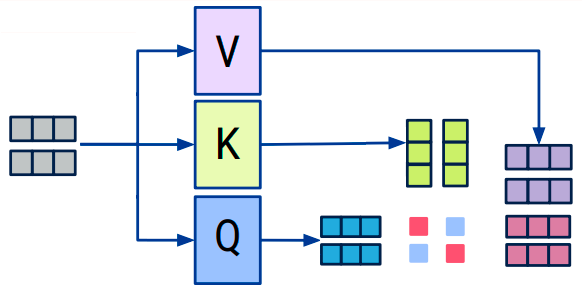</center>

Можно использовать имплементацию с помощью объектно-ориентированного программирования в PyTorch:



```
layer = nn.MultiheadAttention(embed_dim, num_heads)
values, attnention = layer(q_1, k_1, v_1)
```



In [ ]:
embed_dim = 3
seq_1 = torch.randn(2, embed_dim)

num_heads = 1
layer = nn.MultiheadAttention(embed_dim, num_heads)

q_1 = seq_1
k_1 = seq_1
v_1 = seq_1
values, attention = layer(q_1, k_1, v_1)

In [ ]:
print("Q\n", q_1)
print("K\n", k_1)
print("V\n", v_1)
print("Attention\n", attention)
print("Values\n", values)

Q
 tensor([[ 0.4580, -3.3031, -1.4286],
        [ 1.0944,  0.7849,  0.0717]])
K
 tensor([[ 0.4580, -3.3031, -1.4286],
        [ 1.0944,  0.7849,  0.0717]])
V
 tensor([[ 0.4580, -3.3031, -1.4286],
        [ 1.0944,  0.7849,  0.0717]])
Attention
 tensor([[0.1322, 0.8678],
        [0.5878, 0.4122]], grad_fn=<SqueezeBackward1>)
Values
 tensor([[ 0.1017,  0.0566,  0.3487],
        [-0.5268,  0.4453, -0.2613]], grad_fn=<SqueezeBackward1>)


#### Cross-Attention

За исключением входных данных, расчет перекрестного внимания (Cross-Attention) такой же, как и для Self-Attention. Перекрестное внимание асимметрично комбинирует и сравнивает две отдельные последовательности. Одна из последовательностей служит в качестве входных данных запроса, в то время как другая — в качестве входных данных ключа и значения. Альтернативное перекрестное внимание в использует запрос и значение из одной последовательности и ключ из другой. Может использоваться в Multi-Domain задачах.

<center width="100%">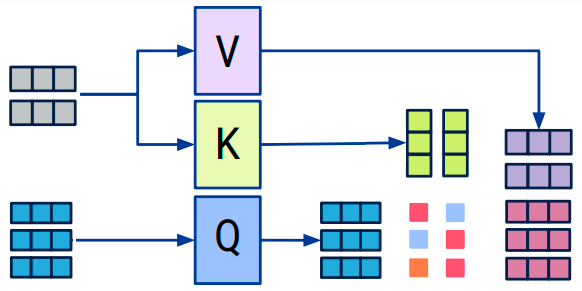</center>

Можно использовать имплементацию с помощью объектно-ориентированного программирования в PyTorch:



```
layer = nn.MultiheadAttention(embed_dim, num_heads)
values, attnention = layer(q_1, k_2, v_2)
# или
values, attnention = layer(q_1, k_2, v_1)
```



In [ ]:
embed_dim = 3
seq_1 = torch.randn(2, embed_dim)
seq_2 = torch.randn(3, embed_dim)

num_heads = 1
layer = nn.MultiheadAttention(embed_dim, num_heads)

q_1 = seq_2
k_1 = seq_1
v_1 = seq_1
values, attention = layer(q_1, k_1, v_1)

In [ ]:
print("Q\n", q_1)
print("K\n", k_1)
print("V\n", v_1)
print("Attention\n", attention)
print("Values\n", values)

Q
 tensor([[-0.9061, -0.5056, -1.1735],
        [ 1.0867,  0.9159,  0.5906],
        [-1.1014, -0.1432, -0.9946]])
K
 tensor([[ 1.3446,  1.2076,  0.6120],
        [-1.6006,  0.4150,  1.7004]])
V
 tensor([[ 1.3446,  1.2076,  0.6120],
        [-1.6006,  0.4150,  1.7004]])
Attention
 tensor([[0.4495, 0.5505],
        [0.3449, 0.6551],
        [0.4876, 0.5124]], grad_fn=<SqueezeBackward1>)
Values
 tensor([[-0.1195,  0.4473,  0.3251],
        [-0.1231,  0.3550,  0.3746],
        [-0.1182,  0.4808,  0.3070]], grad_fn=<SqueezeBackward1>)


#### Проверочная работа №1

Где и в каком количестве на графовом представлении архитектуры используются механизмы:

1. (Scaled) Dot Product Attention
2. Multi-Head Attention
3. Self-Attention
4. Cross-Attention



<center width="100%">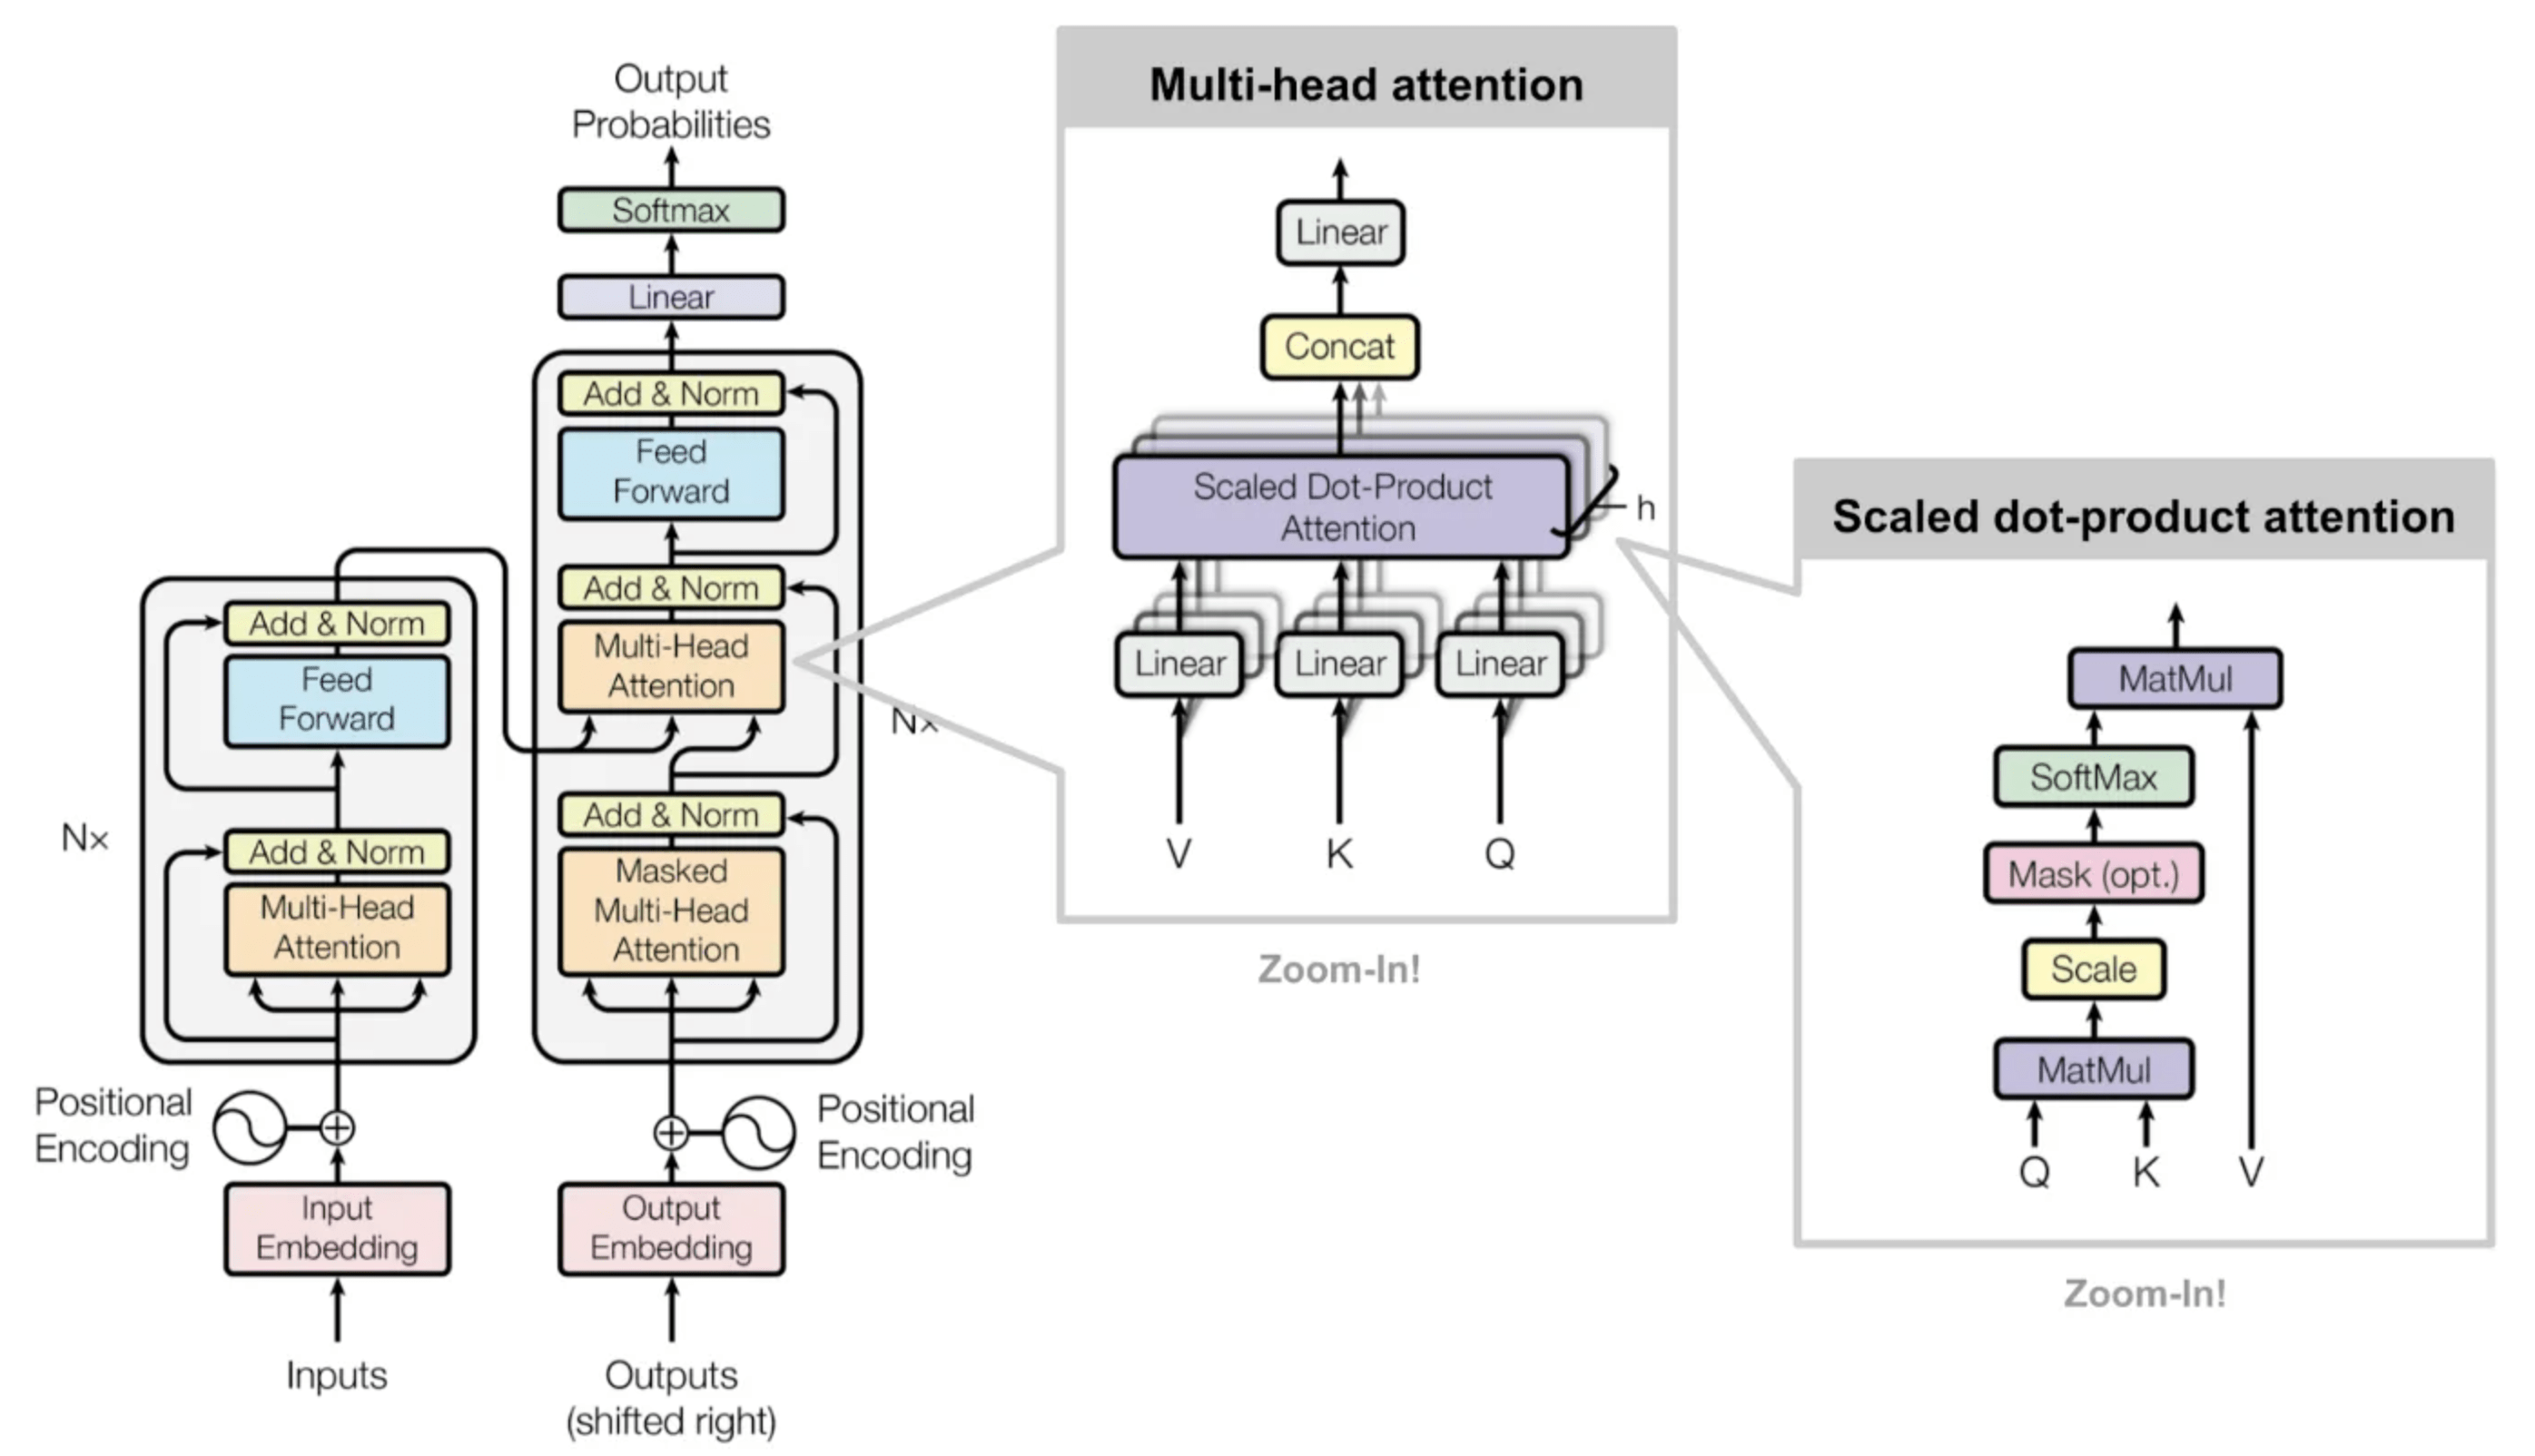</center>

### Базовые модули

#### Channel Attention

Модуль внимания канала (Channel Attention) — это модуль в сверточных нейронных сетях, который создает карту внимания канала, используя межканальные отношения признаков. Поскольку каждый канал карты признаков рассматривается, как детектор признаков, внимание канала фокусируется на том, «что» имеет значение для данного входного изображения.

<center width="100%"><img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-25_at_1.27.21_PM_YDoPGUi.png" width="690px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/channel-attention-module

#### Spatial Attention

Модуль пространственного внимания (Spatial Attention) — это модуль в сверточных нейронных сетях, который создает пространственную карту внимания, используя межпространственные отношения признаков. В отличие от канального внимания, пространственное внимание фокусируется на том, где находится информативная часть, дополняющая канальное внимание.

<center width="100%"><img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-25_at_1.27.27_PM_CjrAZaI.png" width="575px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/spatial-attention-module

#### Многие другие

Неполный, но обширный, список Attention механизмов и модулей вы можете посмотреть на сайте-сборнике SOTA решений:

https://paperswithcode.com/methods/category/attention-mechanisms

### SOTA решения

#### (Shifted) Window Attention

Проблемой Multi-Head Attention является его квадратичная сложность, что вызывает много проблем с вычислительной сложностью при применении на картинках высокого разрешения. Решение представленное авторами Swin Transformer — для каждого токена считать Attention не со всеми другими токенами, а только с находящимися в некотором окне фиксированного размера (Window Mutli-Head Attention). Если размерность токенов — $C$, а размер окна — $M\times M$, то сложности для Multi-Head Self Attention обычного и Window-based получаются следующие:

$$
\begin{split}
    \Omega(\text{MSA})=4hwC^2+2(hw)^2C,\\
    \Omega(\text{W-MSA})=4hwC^2+2(M)^2hwC
\end{split}
$$

То есть Attention теперь работает за линейное по hw время. Однако такой подход уменьшает общую репрезентативную способность сети, так как токены из различных окон никак не будут взаимодействовать. Чтобы исправить ситуацию, после каждого блока с Window Multi-Head Attention добавлен аналогичный слой, со смещёнными по диагонали окнами Attention:

<center width="100%"><img src="https://habrastorage.org/getpro/habr/upload_files/6f6/296/77a/6f629677a902519ce7361d9988ee7446.jpg" width="690px"></center>

Это вернуло взаимодействие между токенами, оставив при этом линейную вычислительную сложность.

Как проиллюстрировано выше, сдвиг окон Attention увеличивает их количество. Это значит, что реализация этого слоя с наивным паддингом исходной «карты» признаков нулями обяжет считать больше Attention-ов (9 вместо 4 в примере), чем мы посчитали бы без сдвига. Чтобы не производить лишних вычислений, авторы предложили перед подсчётом циклически сдвигать само изображение и вычислять уже маскированный Attention, чтобы исключить взаимодействие не соседних токенов. Такой подход вычислительно эффективнее наивного, так как количество вычисляемых Attention не увеличивается:

<center width="100%"><img src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/a41/311/ddf/a41311ddf212743358566bd30c222872.jpg" width="690px"></center>

Также авторы использовали несколько другие positional embedding. Их заменили на обучаемую матрицу $В$, называемую relative position bias, которая прибавляется к произведению query и key под softmax:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}+B\right)V$$

Как оказалось, подобный подод приводит к лучшему качеству.


Подробнее можете ознакомиться в статье:

https://paperswithcode.com/paper/swin-transformer-hierarchical-vision

#### Neighborhood Attention

Внимание к соседям (Neighborhood Attention) — это разновидность ограниченного Self-Attention, в котором рецептивное поле каждого токена ограничено ближайшими к нему соседними пикселями. Он был предложен в Neighborhood Attention Transformer в качестве альтернативы другим механизмам локального внимания.

<center width="100%"><img src="https://production-media.paperswithcode.com/methods/0f2f831e-3d62-4bb9-b953-9736fa8a3d08.png" width="690px"></center>

Ниже русунок с иллюстрацией охвата внимания для подходов Self-Attention, Shifted Window Self Attention и Neighborhood Attention.

<center width="100%">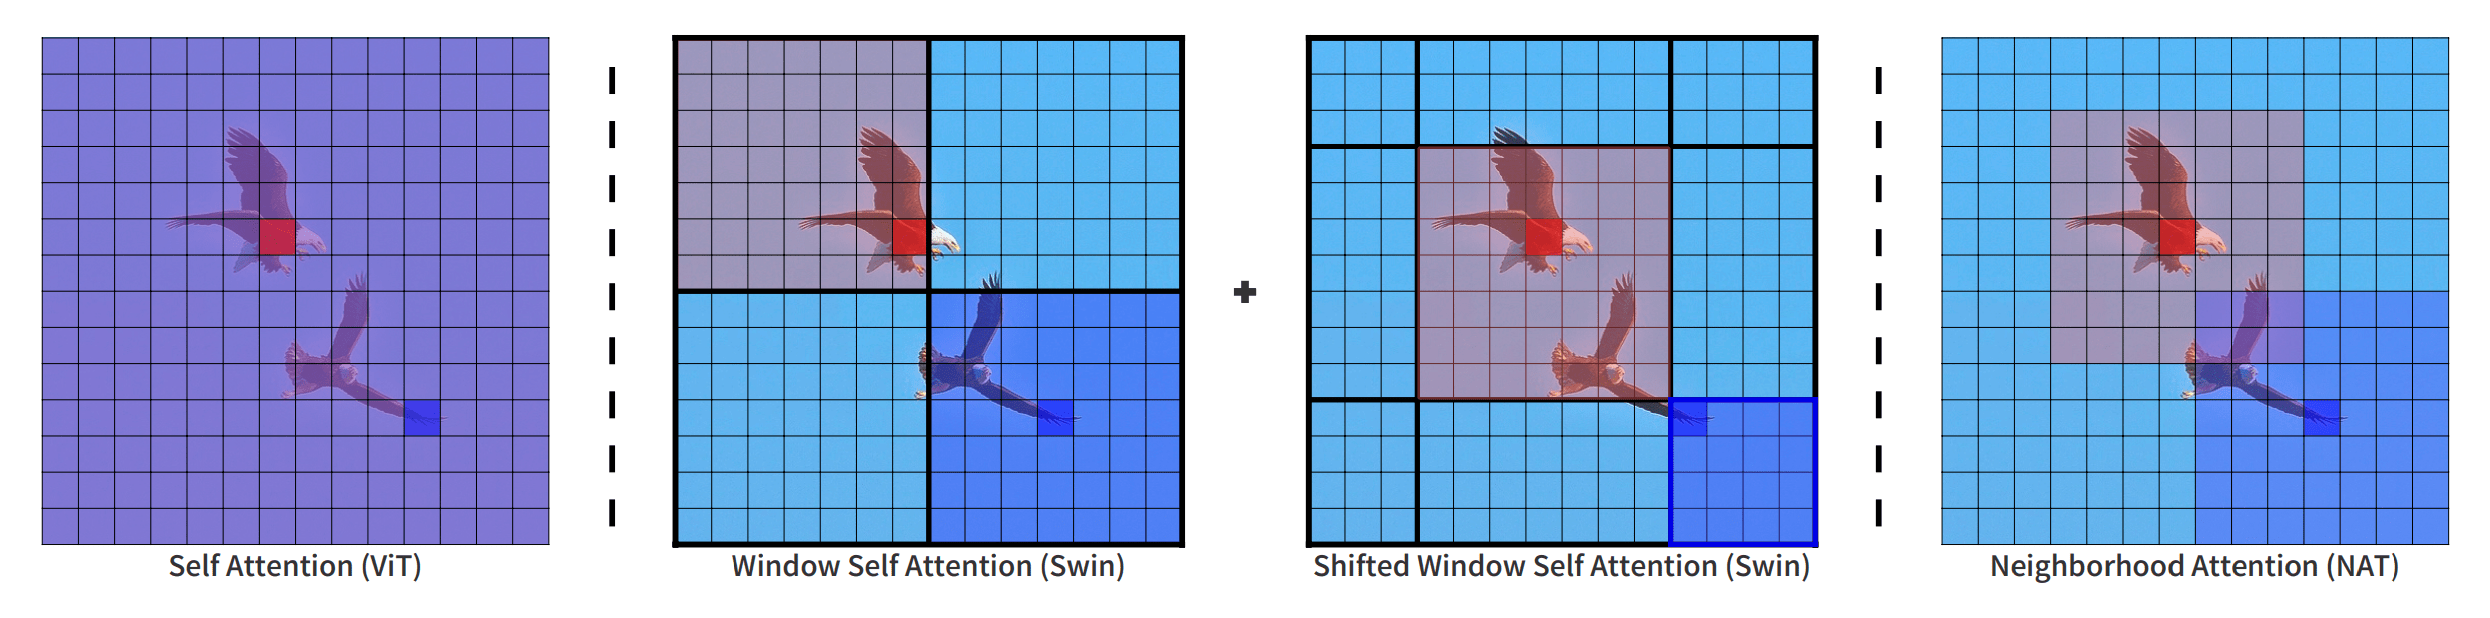</center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/na

#### Large Kernel Attention

Существует два популярных метода построения взаимосвязи между различными частями, токенами. Первый метод заключается в использовании свертки с большим ядром для определния релевантности. Второй метод — это Self-Attention. У того и другого метода существуют свои недостатки:

$$
\begin{array}{c|c|c} \hline
\textbf{Характеристики}&\textbf{Convolution}&\textbf{Self-Attention}\\ \hline
\text{Локальное рецептивное поле}&✓&✗ \\
\text{Глобальное рецептивное поле}&✗&✓ \\
\text{Глобальные зависимости}&✗&✓ \\
\text{Пространственная адаптивность}&✗&✓ \\
\text{Межканальная адаптивность}&✗&✗ \\ \hline
\text{Вычислительная сложность}&O(n)&O(n^2) \\ \hline
\end{array}
$$

*Небольшая иллюстарция рецептивного поля:*
<center width="100%"><img src="https://www.mdpi.com/symmetry/symmetry-13-00397/article_deploy/html/images/symmetry-13-00397-g003.png" width="575px"></center>

Чтобы преодолеть перечисленные выше минусы и использовать плюсы, было предложено разложить операцию свертку с большим ядром, как показано на рисунке ниже, на три компонента: 

1. Пространственная локальная свертку ($DW$)
2. Пространственная свертка на большие расстояния ($DW-D$)
3. Межканальная свертка ($1\times 1$)

И добавить логику аналогичну с механизмом Self-Attention.

<center width="100%"><img src="https://github.com/Visual-Attention-Network/VAN-Classification/raw/main/images/LKA.png" width="920px"></center>

Благодаря данным улучшениям авторы Visual Attention Network (VAN) создали новый механизм Large-Kernel Attention, который на данный момент остается одним из универсальных решений под самые различные задачи CV.

$$
\begin{array}{c|c|c|c} \hline
\textbf{Характеристики}&\textbf{Convolution}&\textbf{Self-Attention}&\textbf{LKA}\\ \hline
\text{Локальное рецептивное поле}&✓&✗&✓ \\
\text{Глобальное рецептивное поле}&✗&✓&✓ \\
\text{Глобальные зависимости}&✗&✓&✓ \\
\text{Пространственная адаптивность}&✗&✓&✓ \\
\text{Межканальная адаптивность}&✗&✗&✓ \\ \hline
\text{Вычислительная сложность}&O(n)&O(n^2)&O(n) \\ \hline
\end{array}
$$

Grad-CAM визуализация:

<center width="100%">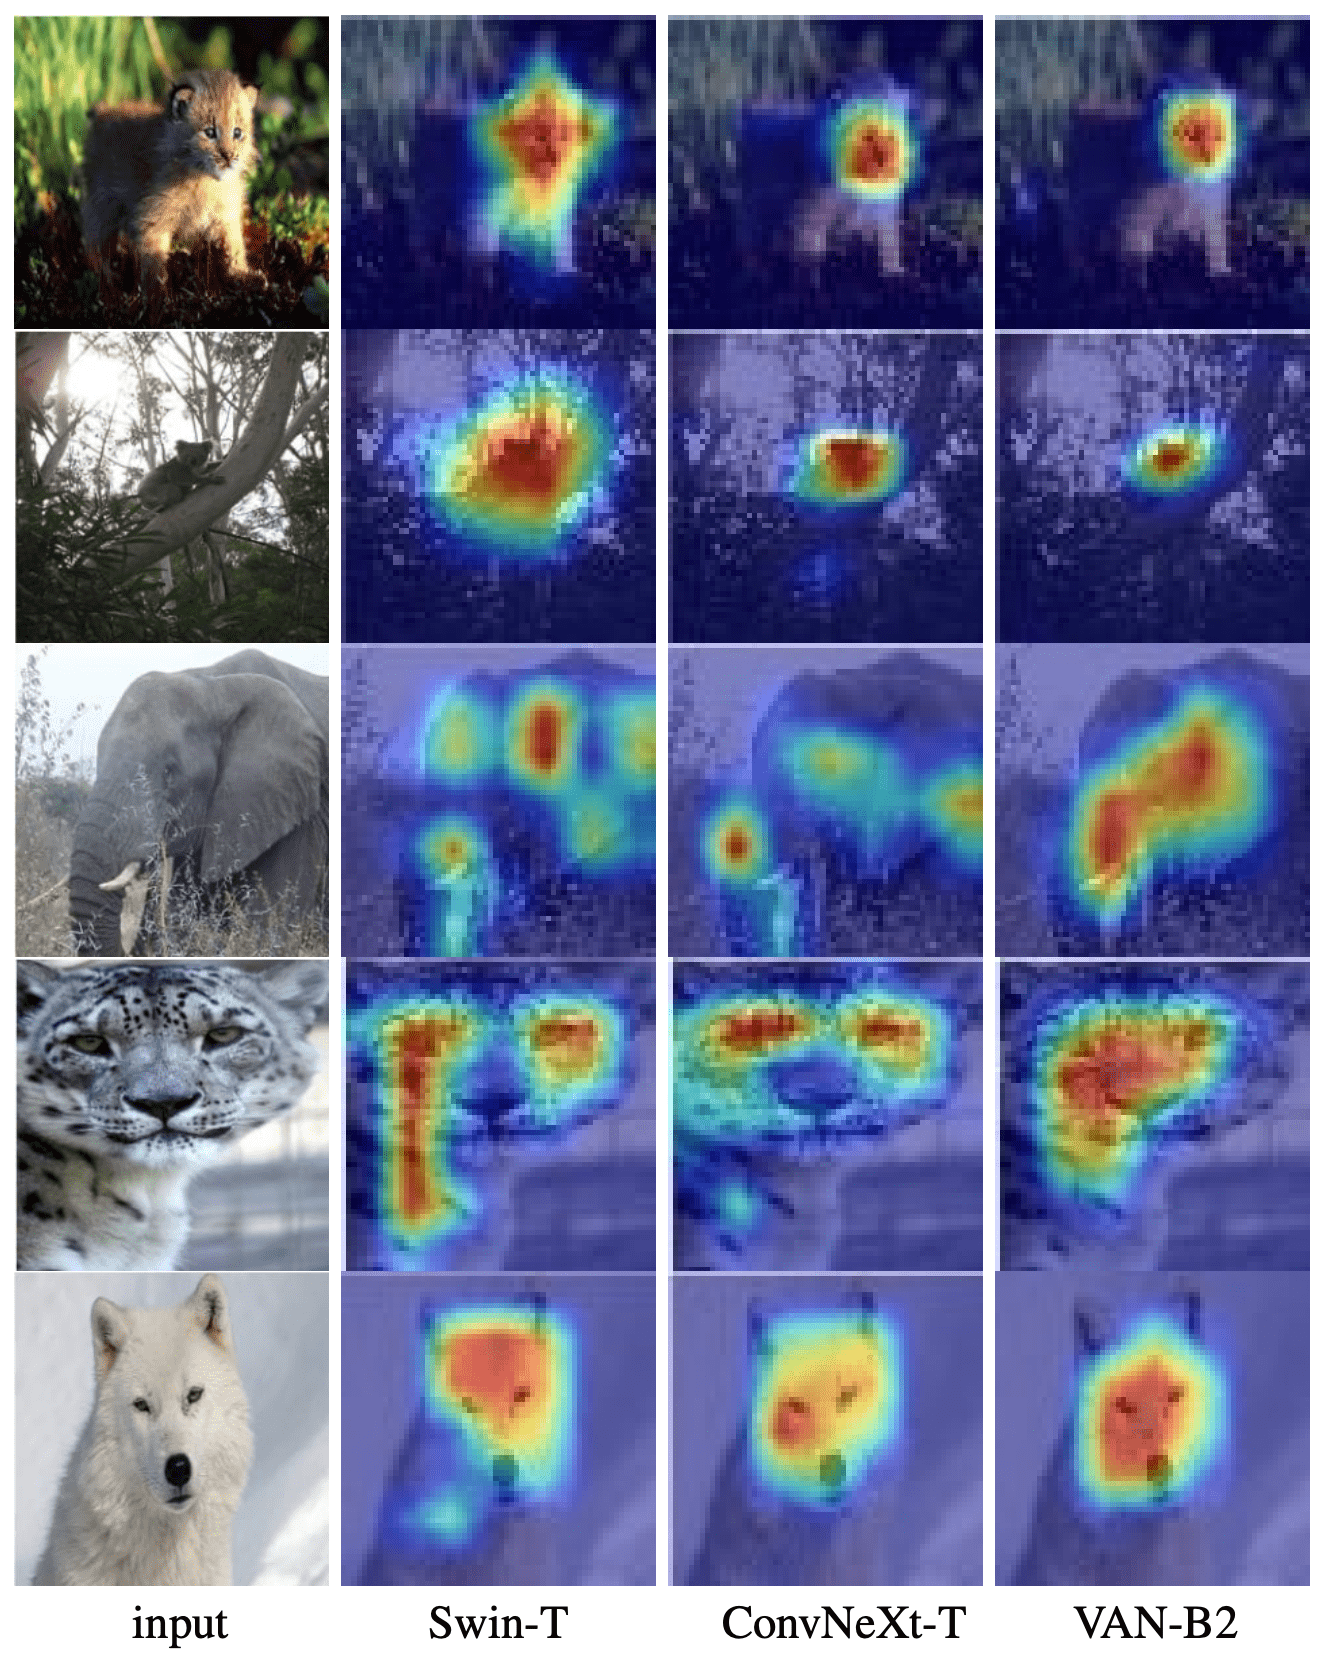</center>

Подробнее можете ознакомиться в статье:

https://arxiv.org/abs/2202.09741

## Архитектура трансформера

NLP — это область, для которой изначально была предложена архитектура трансформера (Transformer) и на которую оказала наибольшее влияние, но она также успешно используется в других областях. В архитектуре Transformer есть огромный потенциал и до конца неизведанные возможности. Не смотря на огромный успех Transformers в NLP, мы не будем включать это в наш обзор здесь, а рассмотрим область CV, то есть трансформеры для обработки изображений.

### Базовые механизмы

#### Layer Normalization

Layer Normalization — это подход, который подразумевает нормализацию выходов от всех нейронов в слою внутри каждого экземпляра, в отличие от выходов каждого нейрона отдельно внутри батча, как в Batch Normalization.

Наиболее известные варианты нормализации представлены ниже. Каждый куб соответствует тензору карты объектов с $N$ в качестве Batch оси, $C$ в качестве оси каналов и $(H, W)$ в качестве пространственных осей высоты и ширины. Пиксели, выделенные серым цветом, нормализуются одним и тем же средним значением и дисперсией, вычисленными агрегацией значений соответвующих пикселей.

<center width="100%">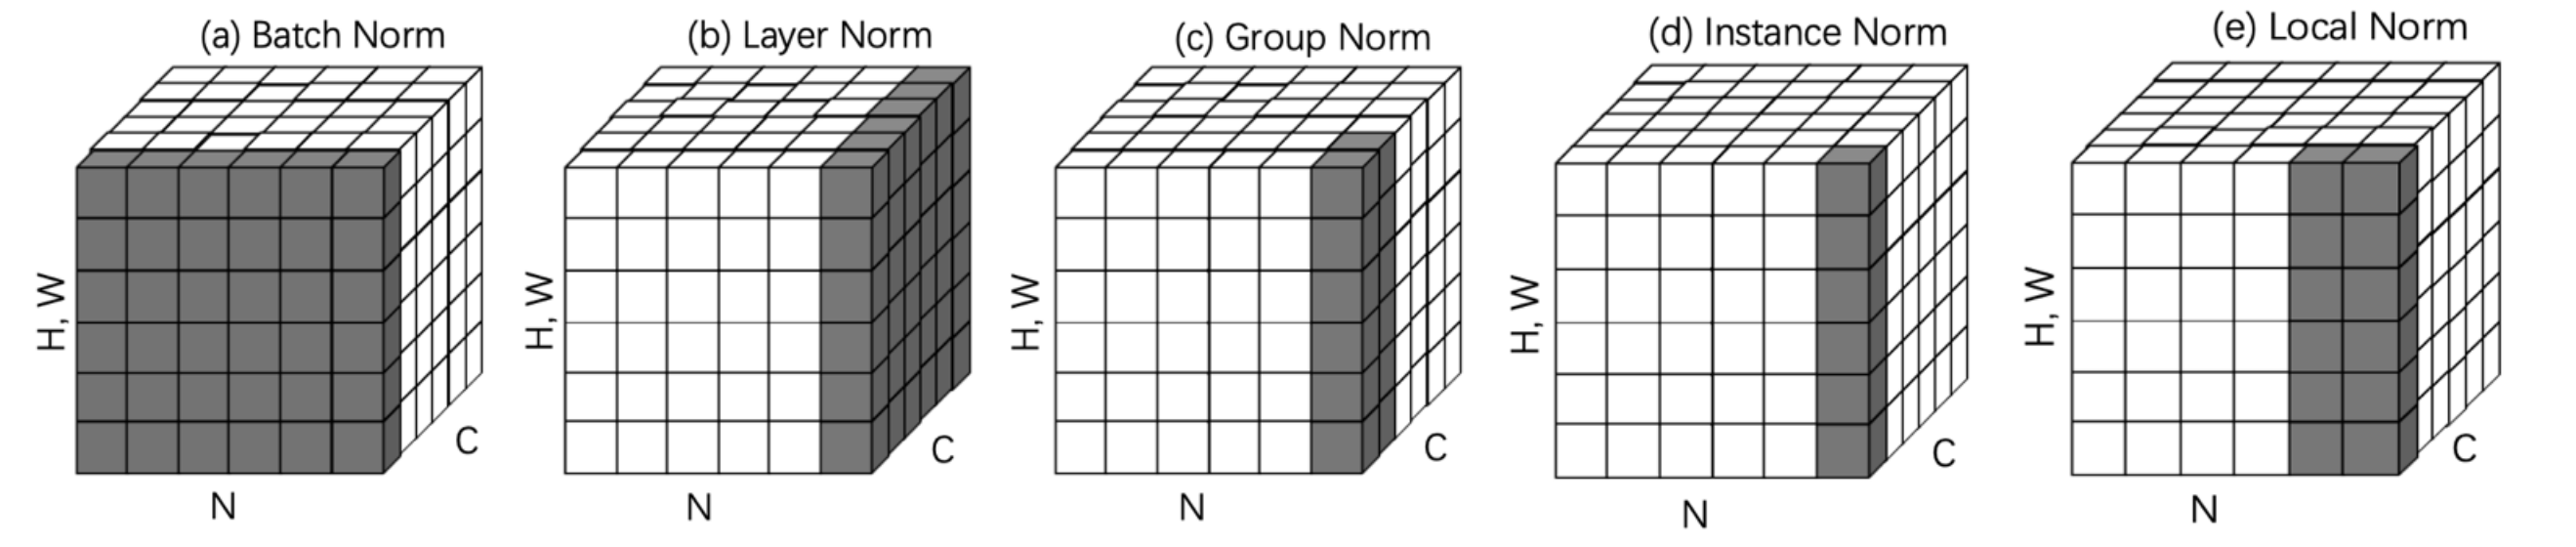</center>

Почему в Attention механизмах используется именно Layer Normalization?

Основная проблема Batch Normalization пришла к нам из задач NLP. Так как длина предложения часто варьируется, при использовании Batch Normalization неясно, какой будут подходящие константы нормализации, что приводит к нестабильности в процессе обучения.

Менее известная проблема Batch Normalization заключается в том, насколько сложно распараллелить модели, нормализованные в пакетном режиме. Поскольку существует зависимость между элементами, возникает дополнительная потребность в синхронизации между устройствами. Хотя это не проблема для большинства моделей, которые используют одно или небольшое количество устройств. Трансформеры частво страдают от этой проблемы, поскольку они полагаются на большие вычислительные мощности, большое количество устройств (в основном GPU), чтобы противостоять высокой сложности алгоритмов. В этом отношении Layer Normalization обеспечивает нормализацию, не подвергаясь сложностям в распараллеливании.

Можно использовать имплементацию с помощью объектно-ориентированного или функционального программирования в PyTorch:



```
layer = nn.LayerNorm(normalized_shape)
x = layer(x)
# или
x = F.layer_norm(x, normalized_shape)
```


Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/layer-normalization



#### Feature Pyramid

Сеть с пирамидой признаков, или Feature Pyramid Network (FPN), — это с нейронная сеть с особым механизмом извлечения извлечения признаков, которое принимает одномасштабное изображение произвольного размера в качестве входных данных и выводит карты признаков пропорционального размера на нескольких заданных уровнях.

Этот процесс не зависит от базовых архитектур. Таким образом, он действует как универсальное решение для построения пирамид признаков внутри глубоких сверточных сетей, которые будут использоваться в различных задачах.

<center width="100%"><img src="https://production-media.paperswithcode.com/methods/new_teaser_TMZlD2J.jpg" width="690px"></center>

Feature Pyramid является одним из главных базовых механизмов многокомпонентных систем распознавания (обычно в CV) для обнаружения объектов в различных масштабах.



<center width="100%"><img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*eFGn4fUKHzLvuCSoH6p0lw.png" width="690px"></center>

Подробнее можете ознакомиться в статье и на сайте-сборнике SOTA решений:

https://paperswithcode.com/method/fpn

https://paperswithcode.com/methods/category/feature-pyramid-blocks

#### Positional Encoding

Многоголовый блок внимания не зависит от перестановок и не может различить, предшествует ли вход другому входу в последовательности или нет. Однако обычно в прикладных задачах позиция очень важна для интерпретации признаков. Таким образом, информация о местоположении может быть добавлена с помощью признаков входных данных. Мы могли бы обучить эмбеддинг для каждой возможной позиции, но это не привело бы к обобщению на динамической длине входной последовательности. Следовательно, более лучшим вариантом является использование паттернов признаков, которые сеть может идентифицировать по объектам и потенциально обобщать на более крупные последовательности. Конкретным паттерном, используемым чаще всего, является синус и косинус функция различных частот:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ представляет кодировку позиции в $pos$ в последовательности и скрытую размерность $i$. Эти значения, объединенные для всех скрытых измерений, добавляются к исходным входным объектам и представляют информацию о местоположении (см визуализацию архитектуру ниже).

<center width="100%"><img src="https://habrastorage.org/webt/59/f0/44/59f04410c0e56192990801.png" width="460px"></center>

Мы различаем четные ($i\text{ mod } 2=0$) и нечетные ($i\text{ mod } 2=1$) скрытые размерности, где мы применяем синус или косинус соответственно. Идея, лежащая в основе этой кодировки, заключается в том, что можно представить $PE_{(pos+k,:)}$ как линейную функцию
из $PE_ {(pos,:)}$, что могло бы позволить модели легко отслеживать относительные положения. Длины волн в различных измерениях варьируются от $2\pi$ до $10000\cdot 2\pi$.

Позиционное кодирование (Positional Encoding) также является одним из главных базовых механизмов многокомпонентных систем распознавания (обычно в Transformers). Ниже приведена имплементация механизма из руководства PyTorch Transformers в NLP с корректировками для наших целей.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """Позиционное кодирование.

        Аргументы:
            d_model: Скрытая размерность входных данных.
            max_len: Максимальная ожидаемая длина последовательности.
        """
        super().__init__()

        # Создайте матрицу из [SeqLen, HiddenDim], представляющую позиционную кодировку для входных данных с max_len
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Тензор, который не является параметром, но должен быть частью состояния модулей.
        # Используется для тензоров, которые должны находиться на том же устройстве, что и модуль.
        # persistent=False сообщает PyTorch не добавлять буфер в state dict (например, когда мы сохраняем модель)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

Чтобы понять позиционную кодировку, мы можем визуализировать ее. Мы сгенерируем изображение позиционной кодировки по скрытой размерности и положению в последовательности. Таким образом, каждый пиксель представляет изменение входных признаков, которое мы выполняем для кодирования определенной позиции.

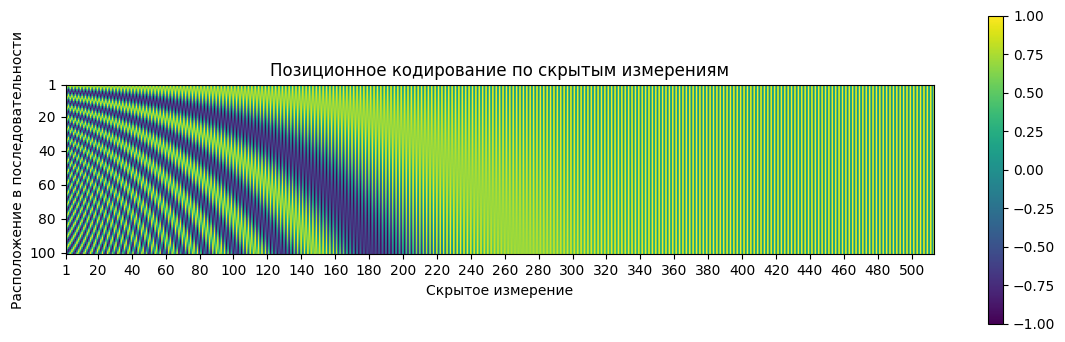

In [ ]:
encod_block = PositionalEncoding(d_model=512, max_len=100)
pe = encod_block.pe.squeeze().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
pos = ax.imshow(pe, extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Скрытое измерение")
ax.set_ylabel("Расположение в последовательности")
ax.set_title("Позиционное кодирование по скрытым измерениям")
ax.set_xticks([1] + [i * 20 for i in range(1, 1 + pe.shape[1] // 20)])
ax.set_yticks([1] + [i * 20 for i in range(1, 1 + pe.shape[0] // 20)])
plt.show()

Вы можете видеть синус и косинус волны с разными длинами, которые кодируют положение в скрытых измерениях. В частности, мы можем посмотреть на синус или косинус волну для каждого скрытого измерения отдельно, чтобы лучше понять закономерность. Ниже мы визуализируем позиционную кодировку для заданных скрытых измерений.

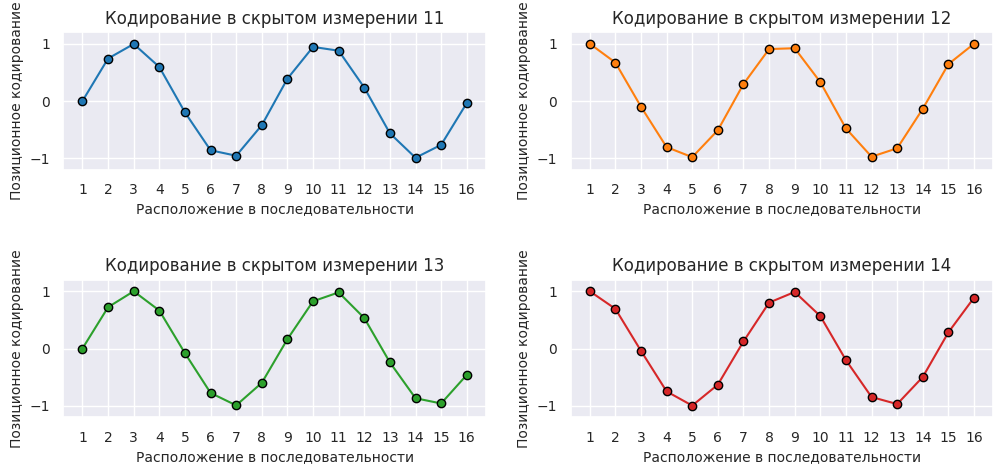

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
ax = [a for a_list in ax for a in a_list]
dims = [10, 11, 12, 13]
for i, d in enumerate(dims):
    ax[i].plot(np.arange(1, 17), pe[:16, d], color="C%i" % i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Кодирование в скрытом измерении %d" % (d + 1))
    ax[i].set_xlabel("Расположение в последовательности", fontsize=10)
    ax[i].set_ylabel("Позиционное кодирование", fontsize=10)
    ax[i].set_xticks(np.arange(1, 17))
    ax[i].tick_params(axis="both", which="major", labelsize=10)
    ax[i].tick_params(axis="both", which="minor", labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

### Базовые архитектуры

#### Transformer

Довольно часто можно встретить архитектуры, когда внутри модели есть две части Encoder и Decoder. Стандартные архитектуры для энкодера и декодера — FFNN, CNN или RNN.

<center width="100%"><img src="https://yuehhua.github.io/images/segnet.svg" width="805px"></center>

Так было в архитектурах прошлых десятилетий. Дальнейшее развитие изменило эту схему с помощью механизма Attention, так на свет появилась первая архитектура Transformer.
 
<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/transformer_architecture.svg" width="460px"></center>

Если есть необходимость в использовании базовой архитектуры, можно использовать имплементацию с помощью объектно-ориентированного программирования в PyTorch:

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

##### Encoder

Encoder — это независимая часть сети, которая получает на вход токены и выдает соответствующие им эмбеддинги, которые в дальнейшем будут использоваться в Decoder. Иногда Encoder в сетях также называют Backbone. Для задач Multi-Domain можно наблюдать несколько различных Encoders или использование слоев Cross-Attention.
 
<center width="100%"><img src="https://habrastorage.org/r/w1560/webt/59/f0/44/59f0440f9359b881372094.png" width="230px"></center>

В представленой графой визуализации архитектуры каждый токен параллельно проходит через слои Encoder. Некоторые из них — это простые Fully-Connected слои в Feed Forward блоке, некоторые — Residual/Shortcut/Skip Connections как в ResNet (на картинке Add).



##### Decoder

Decoder — это вторая независимая часть сети, которая генерирует из полученных в Encoder эмбеддингов необходимые для задачи logits и output. В современных SOTA решениях иногда можно наблюдать несколько различных Decoders, используемых для получения outputs end-to-end модели (например классы и маски в задачах сегментации).

<center width="100%"><img src="https://habrastorage.org/r/w1560/webt/59/f0/44/59f0440f7d88f805415140.png" width="230px"></center>



В представленой графой визуализации архитектуры каждый токен параллельно проходит через слои Decoder. Некоторые из них — это простые Fully-Connected слои в Feed Forward блоке, некоторые — Residual/Shortcut/Skip Connections как в ResNet (на картинке Add). Перед попаданием в блок Feed Forward применяется механизм Cross-Attention между эмбеддингами Encoder (Key и Value) и Output (Query).

##### Визуализация

Визуализация работы Encoder и Decoder в задаче NLP:

<center width="100%"><img src="https://habrastorage.org/getpro/habr/post_images/7d8/a4f/e67/7d8a4fe677ff3afae1bb5dc19762fe69.gif" width="690px"></center>

Визуализация работы Encoder и Decoder (MLP в качестве FFNN) в задаче CV:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/vit.gif?raw=1" width="690px"></center>


#### Проверочная работа №2

Где и в каком количестве на графовом представлении архитектуры используются механизмы:

1. (Scaled) Dot Product Attention
2. Multi-Head Attention
3. Self-Attention
4. Layer Normalization
5. Residual/Shortcut/Skip Connection

<center width="100%"><img src="https://learnopencv.com/wp-content/uploads/2023/02/image-9.png" width="690px"></center>

<font color='red'>$^*$</font>Где и в каком количестве на графовом представлении архитектуры используются механизмы:

1. Dot Product Attention
2. Self-Attention
3. Cross-Attention
4. Layer Normalization
5. Residual/Shortcut/Skip Connection


<center width="100%"><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/mask2former_architecture.jpg" width="460px"></center>

<font color='red'>$^*$</font>Что из представленных графовых визуализаций сетей является Encoder/Backbone и Decoder?

<font color='red'>$^*$</font>Используется ли в данных архитектурах механизм Feature Pyramid? Если да, то где.

### SOTA решения

#### Visual Transformer

Ключевые особенности:

* Базовая реализация Transformer в CV 
* Использование как Encoder/Backbone

Мета архитектура:

<center width="100%"><img src="https://learnopencv.com/wp-content/uploads/2023/02/image-9.png" width="690px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/vision-transformer

#### Swin Transformer

Ключевые особенности:

* (Shifted) Window Attention
* Использование как Encoder/Backbone

Мета архитектура:

<center width="100%"><img src="https://www.researchgate.net/publication/360004380/figure/fig3/AS:1179981581426689@1658340940131/a-Swin-Transformer-architecture-b-Swin-Transformer-blocks.png" width="690px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/method/swin-transformer

#### Mask2Former

Ключевые особенности:

* Стохастическая функция потерь
* Обучаемый Query — PositionalEncoding
* Универсальная сегментация
* Имплементация с Detectron2

Виды сегментаций:

<center width="100%"><img src="https://www.researchgate.net/publication/342409316/figure/fig5/AS:905798087630850@1592970501809/b-semantic-segmentation-c-instance-segmentation-and-d-panoptic-segmentation-for.png" width="460px"></center>

Мета архитектура:

<center width="100%"><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/mask2former_architecture.jpg" width="460px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/paper/masked-attention-mask-transformer-for

#### OneFormer

Ключевые особенности:

* Neighborhood Attention
* Multi-Domian решение
* Универсальная сегментация
* Имплементация с Detectron2

Мета архитектура:

<center width="100%"><img src="https://praeclarumjj3.github.io/oneformer/oneformer.svg" width="920px"></center>

Подробнее можете ознакомиться в статье:

https://paperswithcode.com/paper/oneformer-one-transformer-to-rule-universal

#### Visual Attention Network

Ключевые особенности:

* Large Kernel Attention
* Разные архитектуры для классификации и сегментации
* Имплементация с Hugging Face

Мета архитектура уровня/этапа (stage):

<center width="100%"><img src="https://github.com/Visual-Attention-Network/VAN-Classification/raw/main/images/LKA.png" width="920px"></center>

Grad-CAM визуализация:

<center width="100%">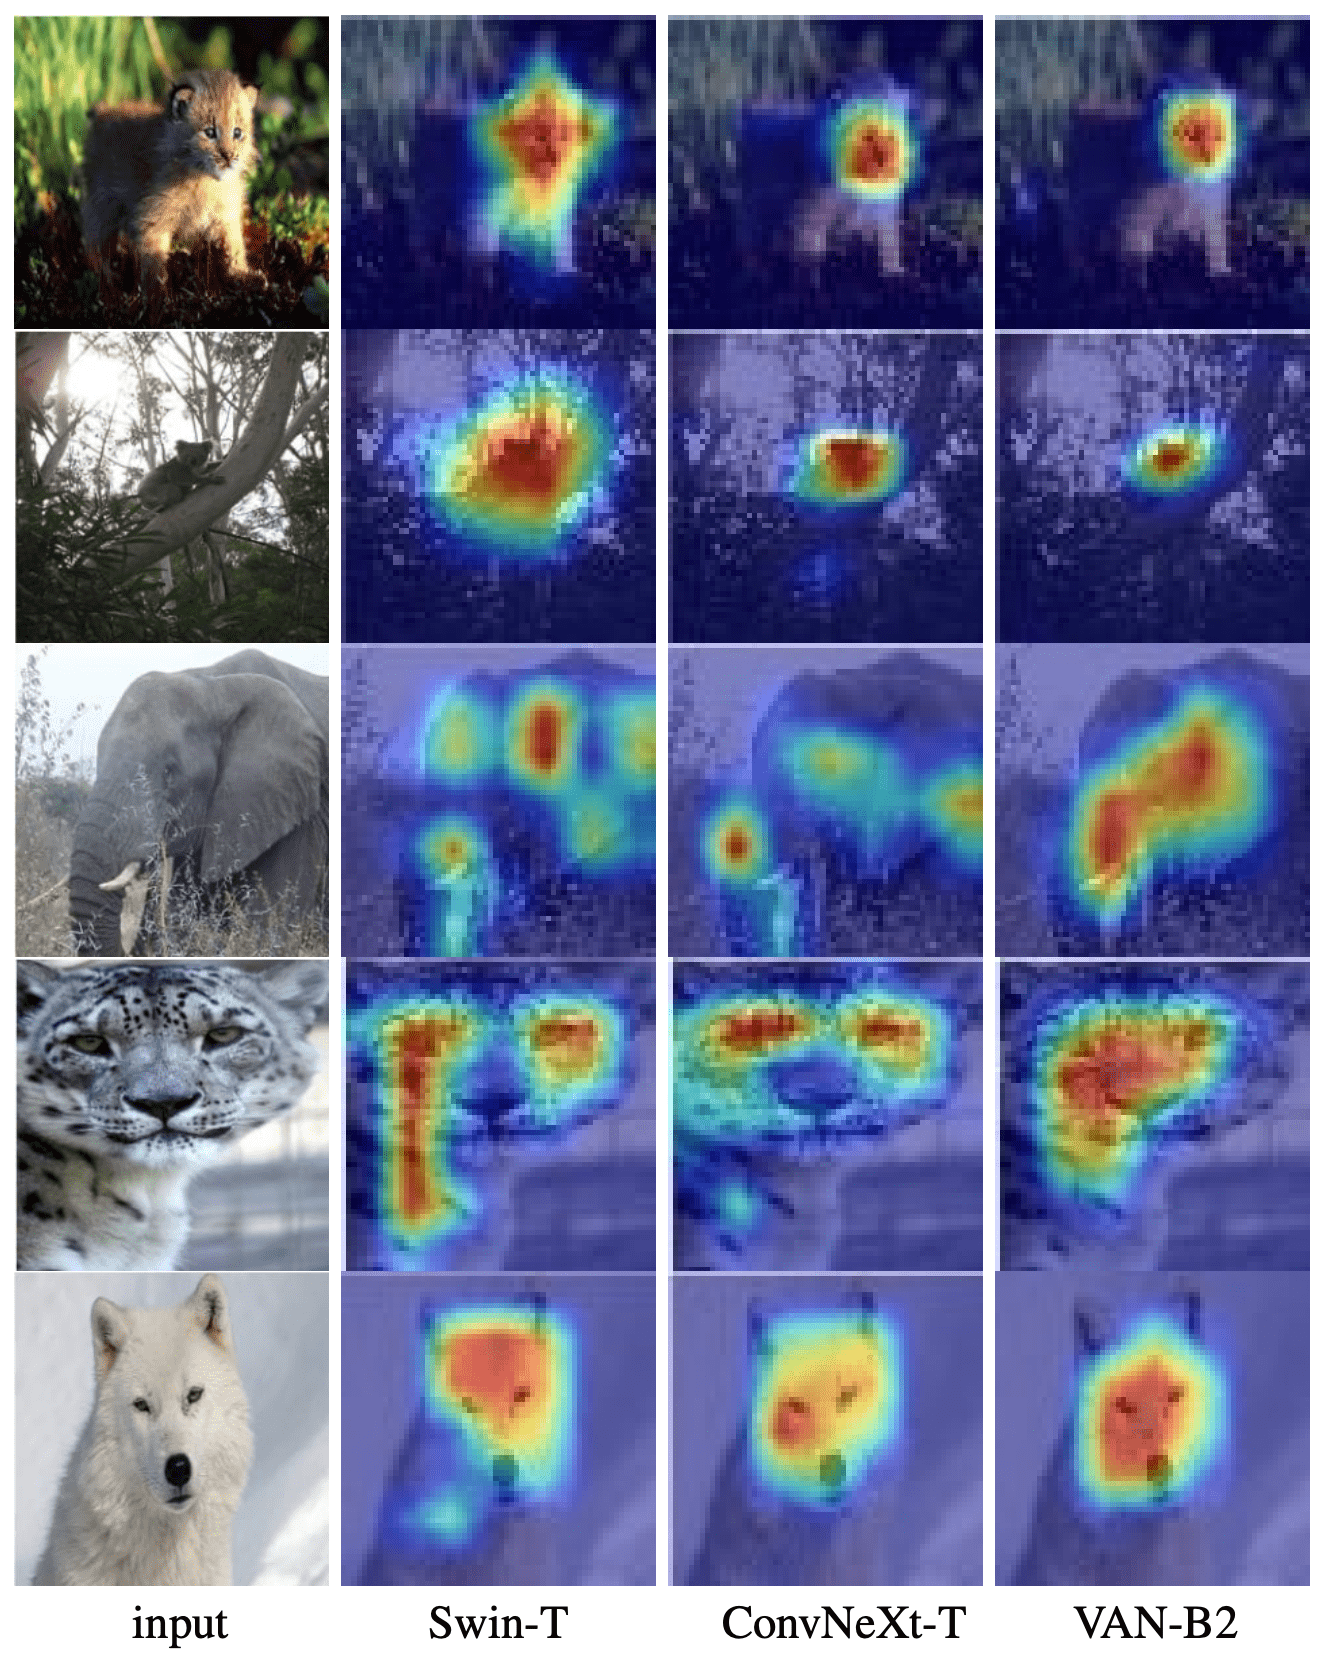</center>

Подробнее можете ознакомиться в статье:

https://arxiv.org/abs/2202.09741

## Frameworks

### Hugging Face

Hugging Face — это коллекция готовых современных предварительно обученных Deep Learning моделей и функций для ускорения работы с ними. Hugging Face Hub содержит более чем 120 000 моделей, 20 000 датасетов и 50 000 демонстраций, благодаря которым люди могут легко имплементировать рабочие процессы и разиваться в области машинного обучения.

<center width="100%"><img src="https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo-with-title.png" width="460px"></center>

Подробнее можете ознакомиться в документации:

https://huggingface.co/docs

#### Демо-сравнение ResNet и VAN

Загрузка датасета и метрики

In [ ]:
dataset = load_dataset("Maysee/tiny-imagenet")
evaluation_dataset = dataset["valid"]

accuracy = evaluate.load("accuracy")

  0%|          | 0/2 [00:00<?, ?it/s]

Выбор картинки для инференса

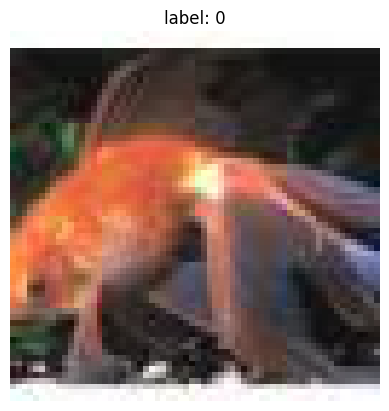

In [ ]:
image = evaluation_dataset["image"][0]
label = evaluation_dataset["label"][0]

plt.imshow(image)
plt.title(f'label: {label}')
plt.axis('off')
plt.show()

ResNet-50

In [ ]:
# Инференс модели на одном изображении из ImageNet с 1000 классами 
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

image = evaluation_dataset["image"][0]
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item() - 1
print(f'Предсказание: {predicted_label} - {model.config.id2label[predicted_label]}')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Предсказание: 0 - tench, Tinca tinca


In [ ]:
# Оценка модели на выборке из 100 валидационных изображений
N = 100

for i in tqdm.notebook.tqdm(range(N)):
    image = evaluation_dataset['image'][i]
    ground_trush = evaluation_dataset['label'][i]

    inputs = processor(image, return_tensors="pt")
    logits = model(**inputs).logits

    predictions = logits.argmax(-1).item() - 1
    accuracy.add(references=ground_trush, predictions=predictions)

result = accuracy.compute()
print('Результат:\n', result)

  0%|          | 0/100 [00:00<?, ?it/s]

Результат:
 {'accuracy': 0.3233082706766917}


VAN-Base/VAN-B2

In [ ]:
# Инференс модели на одном изображении из ImageNet с 1000 классами 
feature_extractor = AutoFeatureExtractor.from_pretrained("Visual-Attention-Network/van-base")
model = VanForImageClassification.from_pretrained("Visual-Attention-Network/van-base")

image = evaluation_dataset["image"][0]
inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item() - 1
print(f'Предсказание: {predicted_label} - {model.config.id2label[predicted_label]}')

Предсказание: 0 - tench, Tinca tinca


In [ ]:
# Оценка модели на выборке из 100 валидационных изображений
N = 100

for i in tqdm.notebook.tqdm(range(N)):
    image = evaluation_dataset['image'][i]
    ground_trush = evaluation_dataset['label'][i]

    inputs = feature_extractor(image, return_tensors="pt")
    logits = model(**inputs).logits

    predictions = logits.argmax(-1).item() - 1
    accuracy.add(references=ground_trush, predictions=predictions)

result = accuracy.compute()
print('Результат:\n', result)

  0%|          | 0/100 [00:00<?, ?it/s]

Результат:
 {'accuracy': 0.42}


### Detectron2

Detectron2 — это фреймворка для распознавания объектов от Facebook. Он полностью реализован на PyTorch, а так же обладает гибким, расширяемым дизайном и может обеспечить быстрое обучение на одном или нескольких серверах GPU. Благодаря модульной реализации Detectron2, с ним легко использовать пользовательские реализации модулей любой части системы обнаружения объектов.

<center width="100%"><img src="https://curiousily.com/static/dff66fd0972574ae284f7df9533d369f/3e3fe/detectron2-logo.png" width="460px"></center>

Подробнее можете ознакомиться в документации:

https://detectron2.readthedocs.io

# Лабораторная работа

Решите задачу классификации на датасете Fashion MNIST, используя предобученную модель Visual Attention Network:

1. Определить необходимые функции
2. Зашрузить модель и предобученные веса
3. Обучить модель с визуализацией функции потерь
4. Используя тестовое множество:
  * Вывести несколько изображений с указанием правильного и предсказанного класса
  * Вывести матрицу ошибок, значение accuracy и f1
5. Сохранить обученную модель


Датасет Fashion MNIST из PyTorch:

https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html

Официальная имплементация VAN на PyTorch:

https://github.com/Visual-Attention-Network/VAN-Classification

Hugging Face имплементация VAN на PyTorch:

https://huggingface.co/docs/transformers/model_doc/van

Комментарии:

1. Рекомендованная имплементация: официальная на PyTorch
2. Рекомендованная размерность модели: VAN-Tiny/VAN-B0
3. Читайте README и ознакамливайтесь с git-файлами train.py и models/van.py
4. Обращайте внимание на размер и количество каналов изображения на входе

<font color='red'>$^*$</font>Визуализируйте карту внимания (Attention Map) последнего слоя Attention модели Visual Attention Network (VAN). Ниже вы можете видеть пример визуализации механизма Multi-Head Attention, где Attention Map из каждой головы обозначен отдельным цветом.

<center width="100%"><img src="https://www.researchgate.net/publication/356251593/figure/fig5/AS:1092643249491968@1637517859330/Visualization-for-self-attention-map-Self-attention-map-from-multiple-heads-are.png" width="690px"></center>